# 2022-09-30 2 Dimensions

## Last time

* Implicit Runge-Kutta methods
* Exploring/discussing tradeoffs
* SciML benchmarks suite (`DifferentialEquations.jl`)

## Today
* FD methods in 2D
* Cost profile
* The need for fast algebraic solvers

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays



RKTable([0.0 0.0 0.0 0.0; 0.5 0.0 0.0 0.0; 0.0 0.75 0.0 0.0; 0.2222222222222222 0.3333333333333333 0.4444444444444444 0.0], [0.2222222222222222 0.3333333333333333 0.4444444444444444 0.0; 0.2916666666666667 0.25 0.3333333333333333 0.125], [0.0, 0.5, 0.75, 1.0])

# Extending advection-diffusion to 2D

## 1 dimension

\begin{align} u_t + (- \kappa u_x + w u)_x &= f(x) & \text{ on } \Omega &= (a,b) \\
u(a) &= g_D(a) & u'(b) &= g_N(b) \end{align}

* Cell Peclet number $\mathrm{Pe}_h = \frac{\lvert w \rvert h}{\kappa}$
  * $\mathrm{Pe}_h \lesssim 1$ avoids oscillations
  * $\mathrm{Pe}_h \gtrsim 1$ is non-stiff for time-dependent model
* Centered versus upwind for advection
* Need uniformly bounded $\kappa \ge \epsilon > 0$
* "Strong form" not defined at discontinuities in $\kappa$
  * Works okay using divergence form and fluxes at staggered points

## 2 dimensions

\begin{align} u_t + \nabla\cdot\big(- \kappa \nabla u + \mathbf{w} u \big) &= f(x,y) & \text{ on } \Omega & \subset \mathbb R^2 \\
u|_{\Gamma_D} &= g_D(x,y) \\
(-\kappa \nabla u + \mathbf w u) \cdot \hat n|_{\Gamma_N} &= g_N(x,y)
\end{align}

* $\Omega$ is some well-connected open set (we will assume simply connected) and the Dirichlet boundary $\Gamma_D \subset \partial \Omega$ is nonempty.
* Finite difference methods don't have an elegant/flexible way to specify boundaries
* We'll choose $\Omega = (-1, 1) \times (-1, 1)$

# On finite difference grids

* Non-uniform grids can mesh "special" domains
  * Rare in 3D; overset grids, immersed boundary methods
* Concept of staggering is complicated/ambiguous

<div>
<img src="/files/Beckers-B-Grid.png" class="floatleft" />
<img src="/files/img/Beckers-C-Grid.png" class="floatright" />
</div>

![Wesseling 11.4: A boundary-fitted grid around an airfoil.](/files/img/Wesseling-Fig11.4-boundary-fitted-grid.png)

# Time-independent advection-diffusion

## Advection

$$ \nabla\cdot(\mathbf w u) = \mathbf w \cdot \nabla u + (\nabla\cdot \mathbf w) u$$

If we choose divergence-free $\mathbf w$, we can use the stencil

$$ \mathbf w \cdot \nabla u \approx \frac 1 h \begin{bmatrix}
& w_2 & \\
-w_1 & & w_1 \\
& -w_2 &
\end{bmatrix} \!:\! \begin{bmatrix}
u_{i-1, j+1} & u_{i, j+1} & u_{i+1,j+1} \\
u_{i-1, j} & u_{i, j} & u_{i+1,j} \\
u_{i-1, j-1} & u_{i, j-1} & u_{i+1,j-1} \\
\end{bmatrix}
$$

# Diffusion

$$ -\nabla\cdot(\kappa \nabla u) = -\kappa \nabla\cdot \nabla u - \nabla\kappa\cdot \nabla u$$
* When would you trust this decomposition?
* If we have constant $\kappa$, we can write
$$
-\kappa \nabla\cdot \nabla u \approx \frac{\kappa}{h^2} \begin{bmatrix}
& -1 & \\
-1 & 4 & -1 \\
& -1 &
\end{bmatrix} \!:\! \begin{bmatrix}
u_{i-1, j+1} & u_{i, j+1} & u_{i+1,j+1} \\
u_{i-1, j} & u_{i, j} & u_{i+1,j} \\
u_{i-1, j-1} & u_{i, j-1} & u_{i+1,j-1} \\
\end{bmatrix}
$$

# Advection-diffusion in code

In [131]:
function advdiff_matrix(n; kappa=1, wind=[1, 1]/sqrt(2))
    h = 2 / n
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx(i, j) = (i-1)*n + j
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    for i in 1:n
        for j in 1:n
            if i in [1, n] || j in [1, n]
                push!(rows, idx(i, j))
                push!(cols, idx(i, j))
                push!(vals, 1.)
            else
                append!(rows, repeat([idx(i,j)], 5))
                append!(cols, [idx(i-1,j), idx(i,j-1), idx(i,j), idx(i+1,j), idx(i,j+1)])
                append!(vals, stencil_advect + stencil_diffuse)
            end
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Spy the matrix

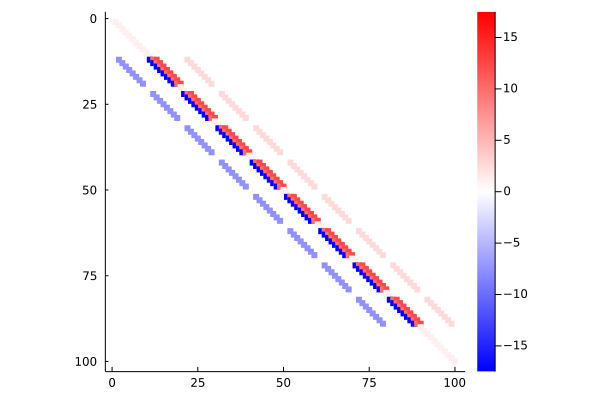

In [108]:
A = advdiff_matrix(10, wind=[1, 3], kappa=.1)
clim = norm(vec(A), Inf)
spy(A, marker=(:square, 3), c=:bwr, clims=(-clim, clim))

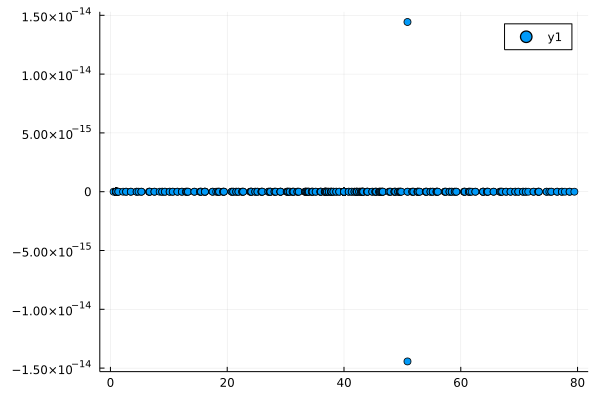

In [113]:
A = advdiff_matrix(20, wind=[0, 0], kappa=.1)
ev = eigvals(Matrix(A))
scatter(real(ev), imag(ev))

# Plot a solution

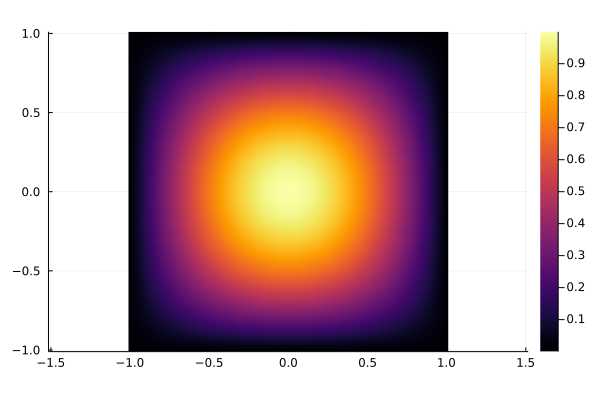

In [124]:
n = 100
x = LinRange(-1, 1, n)
y = x
f = cos.(pi*x/2) * cos.(pi*y/2)'
heatmap(x, y, f, aspect_ratio=:equal)

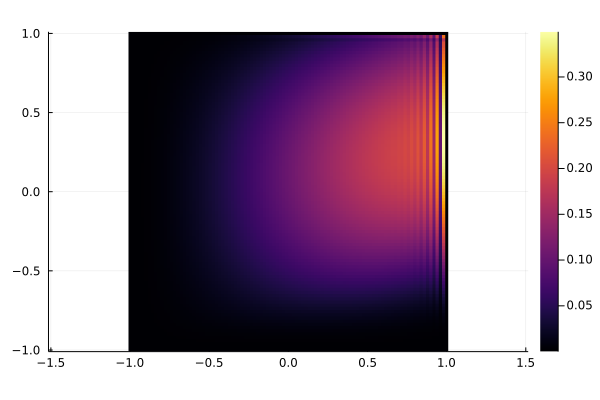

In [127]:
A = advdiff_matrix(n, wind=[3,1], kappa=.01)
u = A \ vec(f)
heatmap(x, y, reshape(u, n, n), aspect_ratio=:equal)

* What happens when advection dominates?
* As you refine the grid?

# Cost breadown and optimization

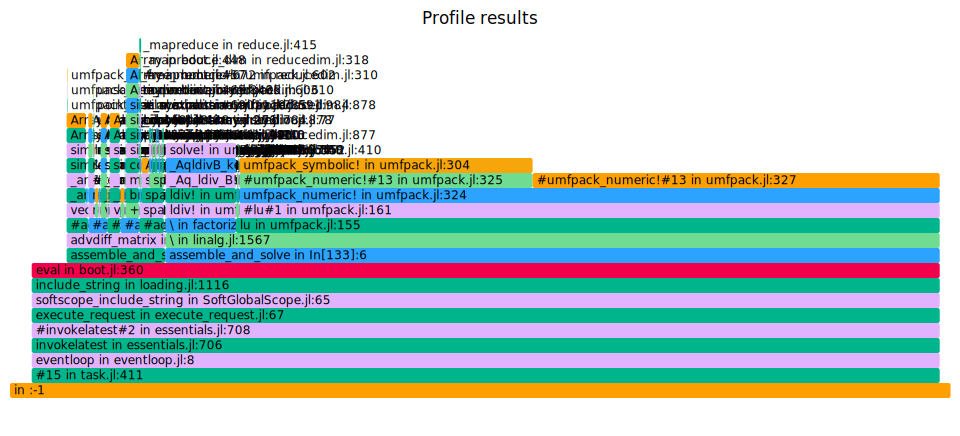

In [133]:
using ProfileSVG
function assemble_and_solve(n)
    A = advdiff_matrix(n)
    x = LinRange(-1, 1, n)
    f = cos.(pi*x/2) * cos.(pi*x/2)'
    u = A \ vec(f)
end

@profview assemble_and_solve(600)

# What's left?

* Symmetric Dirichlet boundary conditions
* Symmetric Neumann boundary conditions
* Verification with method of manufactured solutions
* Non-uniform grids
* Upwinding for advection-dominated problems
* Variable coefficients
* Time-dependent problems
* Fast algebraic solvers